### About PCA

PCA simplifies the complexity of high-dimensional data while keeping its trends and patterns. It does this by transforming the data into a new coordinate system, where the greatest variance by any projection of the data comes to lie on the first coordinate (PCA1), the second greatest variance on the second coordinate, and so on.

By comparing the PCA results of proteomics, metabolomics, and lipidomics data, we can identify if one type of omics data diverges significantly from the others, indicating potential issues or unique characteristic (+ outlier detection)

[Nice Explanation](https://www.reneshbedre.com/blog/principal-component-analysis.html)

In [5]:
import pandas as pd
from helper import *
import seaborn as sns
from sklearn.decomposition import PCA
import cv2
import matplotlib.pyplot as plt
import numpy as np

colors = sns.color_palette("Set2", 8)

In [6]:
path = "C:/Users/mjgoj/Desktop/THESIS/data/final_dataset_split.xlsx"
xls = pd.ExcelFile(path)

metabolomics = pd.read_excel(xls, "Metabolomics")
lipidomics = pd.read_excel(xls, "Lipidomics")
proteomics = pd.read_excel(xls, "Proteomics")
metabolomics_pareto = pd.read_excel(xls, "Pareto Metabolomics")
proteomics_pareto = pd.read_excel(xls, "Pareto Proteomics")

In [7]:
# Standardize the data
metabolomics.iloc[:, 3:] = standardize(metabolomics.iloc[:, 3:])
lipidomics.iloc[:, 3:] = standardize(lipidomics.iloc[:, 3:])
proteomics.iloc[:, 3:] = standardize(proteomics.iloc[:, 3:])
metabolomics_pareto.iloc[:, 3:] = standardize(metabolomics_pareto.iloc[:, 3:])
proteomics_pareto.iloc[:, 3:] = standardize(proteomics_pareto.iloc[:, 3:])


### PCA for each dataset separately

In [8]:
def PCA_analysis(data_, labels, n=10, title=""):
    
    # Create a PCA model
    pca_ = PCA(n_components=n)
    # Fit the model with X and apply the dimensionality reduction on X
    principal_components_ = pca_.fit_transform(data_)
    
    # Create a bar plot for the variance explained by each component
    variance_df = pd.DataFrame({
        'PC':range(1, len(pca_.explained_variance_ratio_)+1), 
        'variance':pca_.explained_variance_ratio_})
    plt.figure(figsize=(6.0, 3.0))
    sns.barplot(x='PC', y='variance', data=variance_df, palette='crest')
    plt.title('Variance explained by each principal component (' + title + ')')
    plt.grid()
    plt.show()
    
    # Create a scores plot highlighting the classes
    scores_df = pd.DataFrame(data = principal_components_[:, :2], columns = ['PC1', 'PC2'])
    # add the labels of the classes to color the samples
    scores_df['label'] = labels
    plt.figure(figsize=(5.5, 3.5))
    sns.scatterplot(x='PC1', y='PC2', data=scores_df, palette='crest', hue='label')
    plt.title('PCA Score Plot (' + title + ')')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    # Adjust the legend
    plt.legend(loc='center left', labels=labels.unique(), bbox_to_anchor=(1, 0.5))
    plt.show()

C:\Users\mjgoj\AppData\Local\Temp\ipykernel_9612\2898376081.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PC', y='variance', data=variance_df, palette='crest')


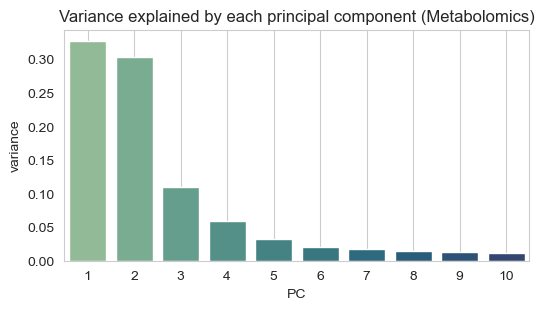

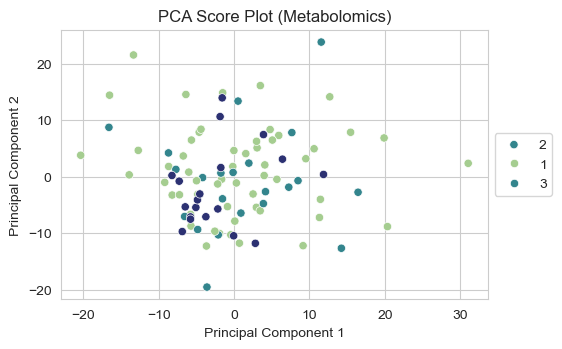

In [9]:
PCA_analysis(
    metabolomics[metabolomics.columns[3:]], metabolomics["ThreeClass"], title="Metabolomics")

C:\Users\mjgoj\AppData\Local\Temp\ipykernel_9612\2898376081.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PC', y='variance', data=variance_df, palette='crest')


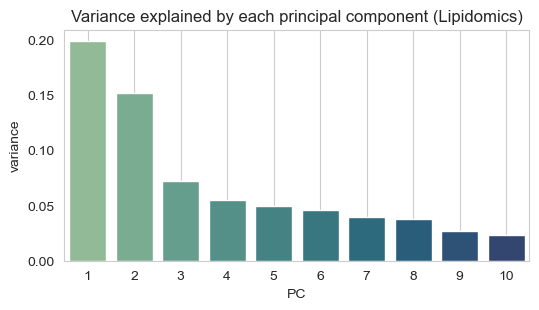

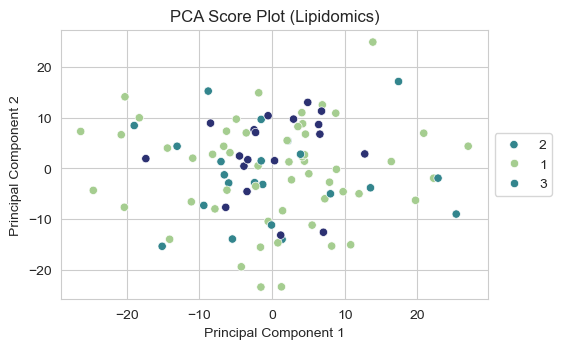

In [10]:
PCA_analysis(lipidomics[lipidomics.columns[3:]], lipidomics["ThreeClass"], title="Lipidomics")

C:\Users\mjgoj\AppData\Local\Temp\ipykernel_9612\2898376081.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PC', y='variance', data=variance_df, palette='crest')


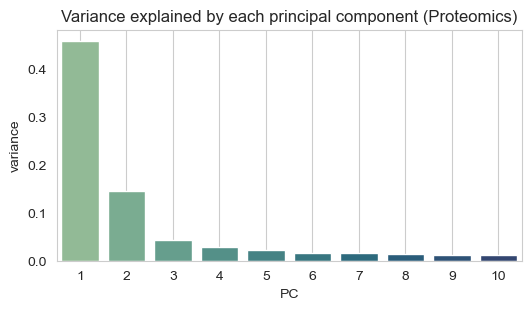

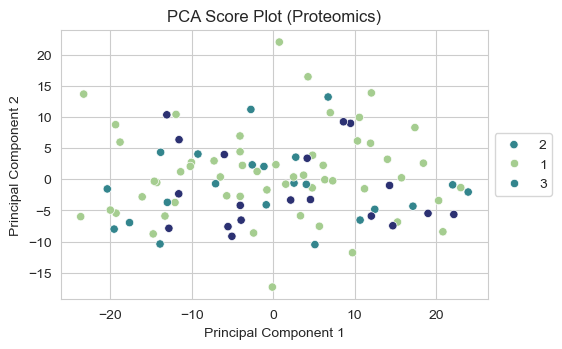

In [11]:
PCA_analysis(proteomics[proteomics.columns[3:]], proteomics['ThreeClass'], title="Proteomics")

### PCA for all the datasets combined

In [27]:
def loadings_plot(data_, features_, num_features=None, text=False, save_path=None):
    """
    Create a loadings plot for the PCA model
    :param data_: Combined data used to fit the PCA model
    :param features_: labels for th data type of the features
    :param num_features: Number of most contributing features to display on the loadings plot
    (default is None, which will display all features)
    :param text: Whether to display the feature names on the loadings plot (default is False)
    """
    plt.figure(figsize=(6, 5))
    colors_ = sns.color_palette("magma", 3)
    pca_ = PCA(n_components=10)
    # Fit the model with X and apply the dimensionality reduction on X
    pca_.fit_transform(combined_data)
    
    # Map the colors to the omics types
    color_map = {}
    # Assign a color to each feature based on its dataset
    for idx, feature_set in enumerate(features_):
        for feature in feature_set:
            color_map[feature] = colors_[idx]
            
    loadings = pca_.components_.T * np.sqrt(pca_.explained_variance_)
    # For PC1 and PC2
    for i in range(2):
        if num_features is not None:
            sorted_idx = np.argsort(np.abs(loadings[:, i]))[::-1]
            top_features = sorted_idx[:num_features]
        else:
            top_features = range(len(data_.columns))
        for feature in top_features:
            # Use the color map to set arrow color
            # Default to black if not found
            color = color_map.get(combined_data.columns[feature], 'black')
            plt.arrow(
                0, 0, loadings[feature, i]*5, loadings[feature, i+1]*5, color=color, alpha=0.65)
            if text:
                plt.text(
                    loadings[feature, i]*5, loadings[feature, i+1]*5,
                    f"{combined_data.columns[feature]}", color=color, ha='center', va='center'
                )
    # Add legend for the omics types
    labels = ['Metabolomics', 'Lipidomics', 'Proteomics']
    for idx, label in enumerate(labels):
        plt.scatter([], [], color=colors_[idx], label=label)
    
    plt.legend(
        scatterpoints=1, frameon=True, labelspacing=1, 
        title='Omics type', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    title = 'PCA Loadings Plot'
    if num_features is not None:
        title += f' (Top {num_features} features)'
    plt.title(title)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

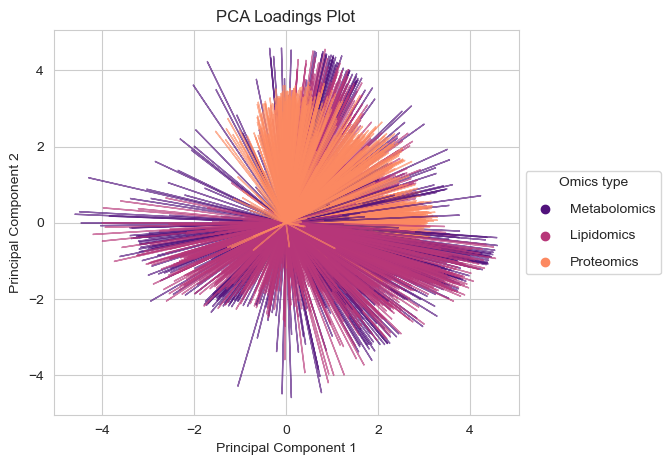

In [13]:
combined_data = pd.concat([
    metabolomics.iloc[:, 3:], 
    lipidomics.iloc[:, 3:], 
    proteomics.iloc[:, 3:]], axis=1)
feature_sets = [metabolomics.columns[3:], lipidomics.columns[3:], proteomics.columns[3:]]
loadings_plot(combined_data, feature_sets)

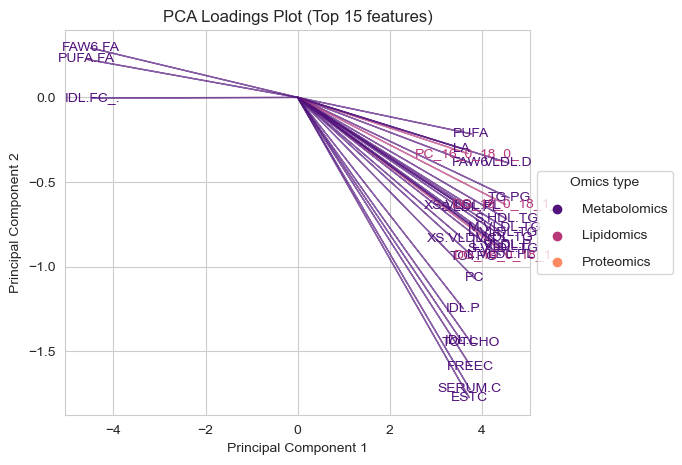

In [32]:
loadings_plot(combined_data, feature_sets, 15, True)

In [26]:
def transposed_scores_plot(metabolomics_, lipidomics_, proteomics_, save_path=None):
    
    # Prepare the data for the PCA and plotting
    combined_data_ = pd.concat([
        metabolomics_.iloc[:, 3:], lipidomics_.iloc[:, 3:], proteomics_.iloc[:, 3:]], axis=1)
    transposed_data = combined_data_.T
    
    # Create a list of labels for the samples (data type of the sample)
    transposed_labels = []
    for i in range(len(metabolomics_.columns) - 3):
        transposed_labels.append("Metabolomics")
    for i in range(len(lipidomics_.columns) - 3):
        transposed_labels.append("Lipidomics")
    for i in range(len(proteomics_.columns) - 3):
        transposed_labels.append("Proteomics")
    
    # Create a PCA model
    pca = PCA(n_components=2)
    # Fit the model with X and apply the dimensionality reduction on X
    principal_components = pca.fit_transform(transposed_data)
        
    # Create a scores plot highlighting the classes
    scores_df = pd.DataFrame(data = principal_components[:, :2], columns = ['PC1', 'PC2'])
    # add the labels of the classes to color the samples
    scores_df['label'] = transposed_labels
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='PC1', y='PC2', data=scores_df, palette="magma", hue='label', alpha=0.65)
    plt.title('PCA Score Plot')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    # Adjust the legend
    plt.legend(
            scatterpoints=1, frameon=True, labelspacing=1, 
            title='Omics type', loc='center left', bbox_to_anchor=(1, 0.5))
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

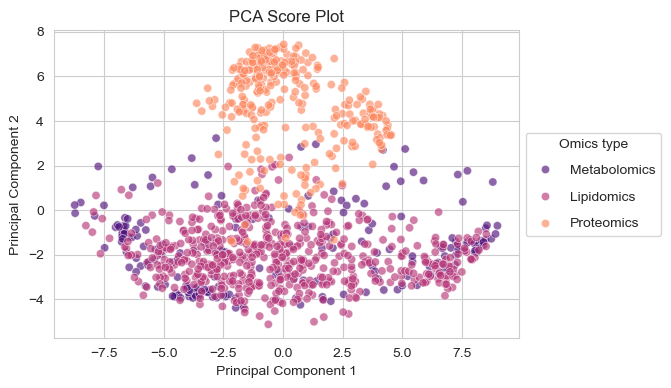

In [16]:
transposed_scores_plot(metabolomics, lipidomics, proteomics)

### Pareto Scaled Metabolomics included

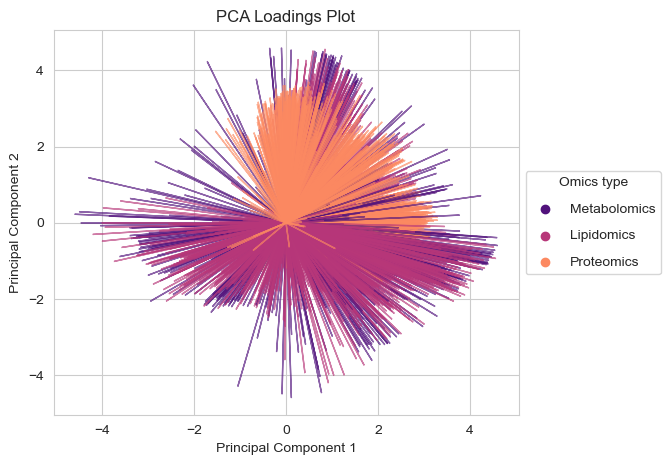

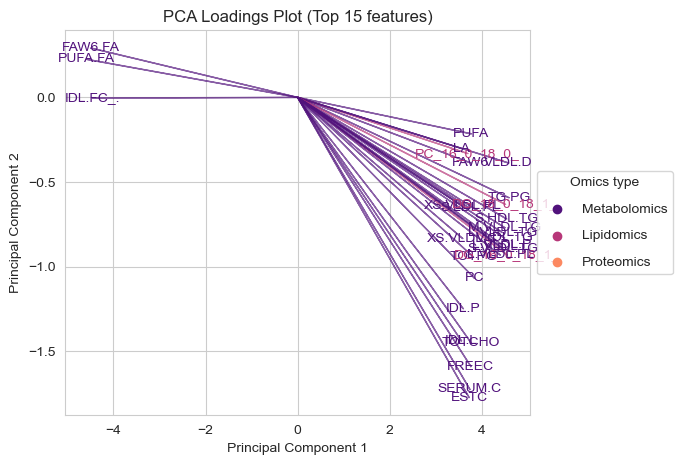

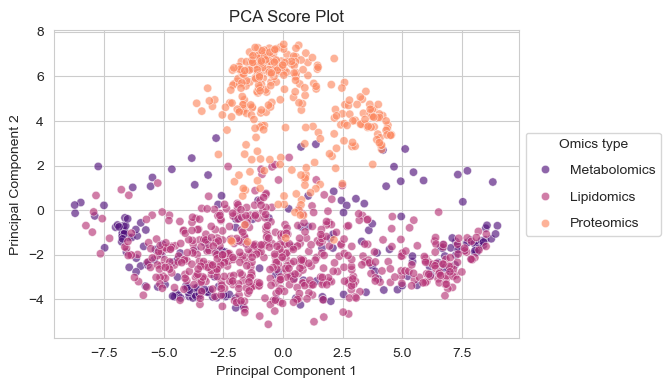

In [29]:
combined_data = pd.concat([
    metabolomics_pareto.iloc[:, 3:], 
    lipidomics.iloc[:, 3:], 
    proteomics.iloc[:, 3:]], axis=1)
feature_sets = [metabolomics_pareto.columns[3:], lipidomics.columns[3:], proteomics.columns[3:]]

loadings_plot(combined_data, feature_sets)
loadings_plot(
    combined_data, feature_sets, 15, True,
    "plots/loadings_before.png"
)
transposed_scores_plot(
    metabolomics_pareto, lipidomics, proteomics,
    "plots/scores_plot_before_normalization.png"
)

### Pareto Scaled Metabolomics and Proteomics included

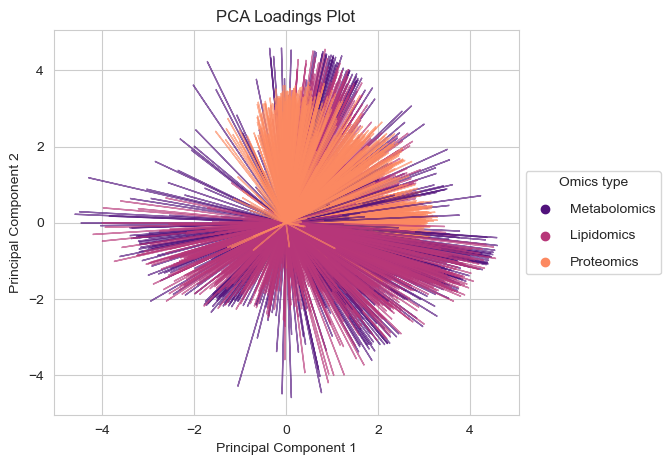

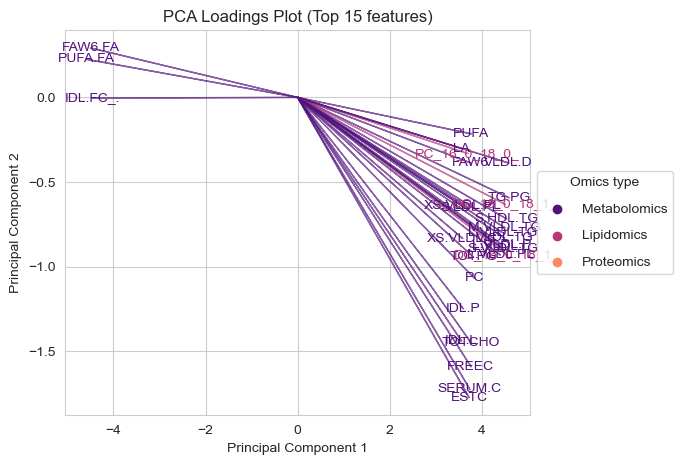

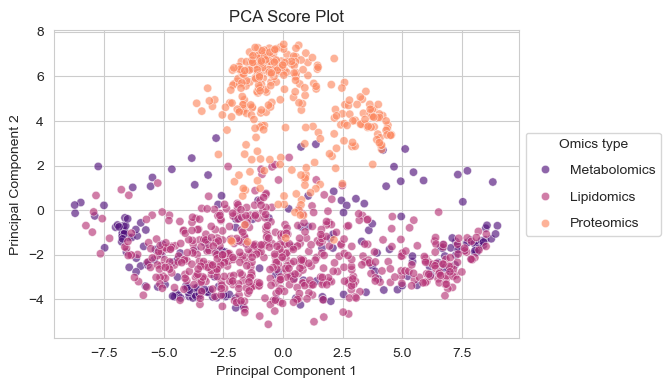

In [28]:
combined_data = pd.concat([
    metabolomics_pareto.iloc[:, 3:], 
    lipidomics.iloc[:, 3:], 
    proteomics_pareto.iloc[:, 3:]], axis=1)
feature_sets = [
    metabolomics_pareto.columns[3:], lipidomics.columns[3:], proteomics_pareto.columns[3:]]

loadings_plot(combined_data, feature_sets)
loadings_plot(
    combined_data, feature_sets, 15, True,
    "plots/loadings_after.png"
)
transposed_scores_plot(
    metabolomics_pareto, lipidomics, proteomics_pareto, 
    "plots/scores_plot_after_normalization.png")

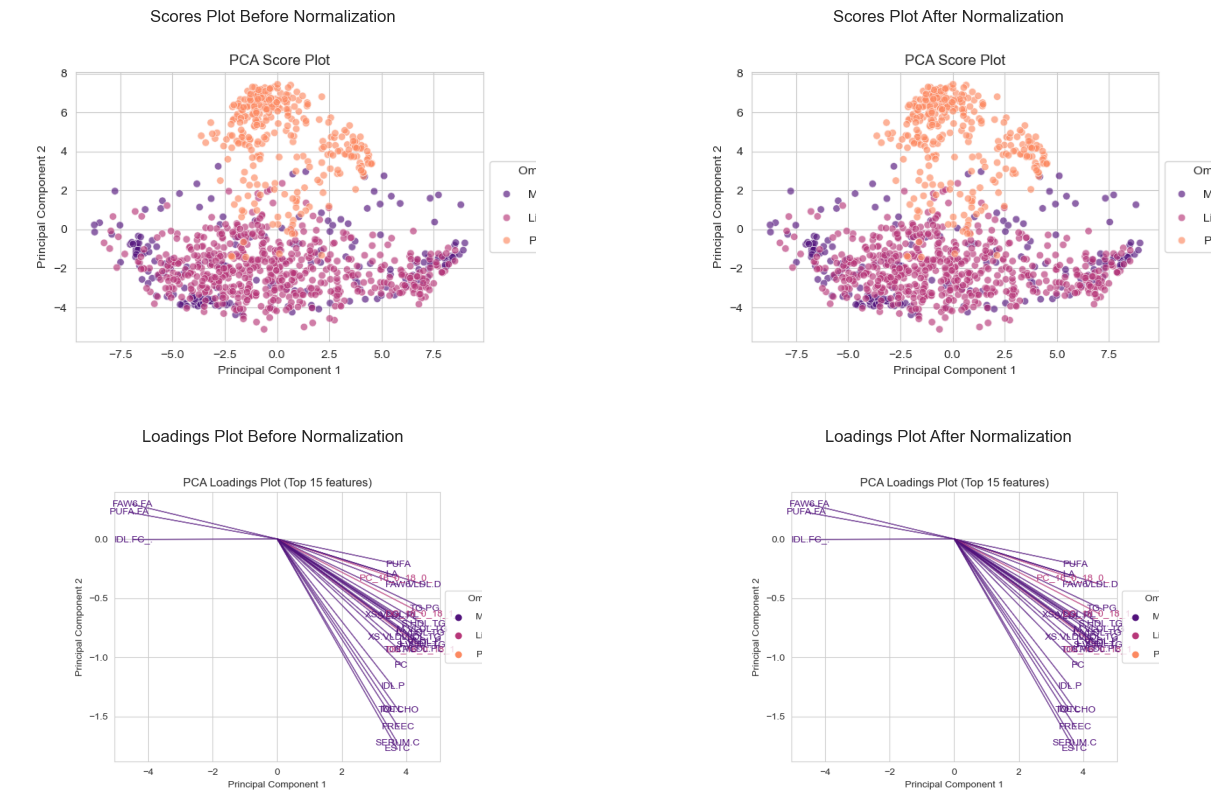

In [30]:
images = [
    cv2.imread('plots/scores_plot_before_normalization.png'),
    cv2.imread('plots/scores_plot_after_normalization.png'),
    cv2.imread('plots/loadings_before.png'), cv2.imread('plots/loadings_after.png')
]
titles = [
    'Scores Plot Before Normalization', 'Scores Plot After Normalization',
    'Loadings Plot Before Normalization', 'Loadings Plot After Normalization'
]
# Show them side by side
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)

for i in range(4):
    image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, i+1)
    plt.imshow(image)
    plt.title(titles[i])
    plt.axis('off')
plt.show()

# TODO

1. ~~Interpret the PCA results before and after scaling, that is pretty important~~
2. ~~Find out whether other omics datasets do also need scaling~~
3. Look at the concatenation of the datasets with scaling based on the dataset size
4. Look at the framework for the testing and integrate the initial feature filtering there
5. Implement baseline models for prediction
    - **Random Forest**
        - **XG Boost** - samples that are not well predicted have more weight
        - **Training with metrics** (for example balanced accuracy)
    - **PLS-Da**
        - SVM (linear and non-linear)
        - Add Loading plot of PLS-DA (interpretability)
        - **(s)PLS-DA** (add regularization)

    - Lasso Regression
        
6. Finish the integration paper and read in depth the one Rachel sent

7. **Create a baseline where prediction is made for each dataset separately**
    - Compare the accuracy for each dataset separately
    - Build separate (tree) model for each dataset, then create ensemble of models with voting

8. **Elastic Net** (linear regression with l1 and l2 regularization)

9. **Define a Pipe for the Data** and train models on separate datasets